In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
from sklearn import svm
from sklearn.model_selection import KFold
from io import StringIO
import tensorflow as tf


good_g4 = np.loadtxt('good_names.txt',dtype=np.str)
labels = np.loadtxt('labels.txt',dtype=np.str)


OSError: ignored

# Pre traitement

In [ ]:
database = []

for name in good_g4:
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+44]!= "_Atom_chem_shift.Assigned_chem_shift_list_ID":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_start = following_line(text,ind_start)

    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')
    database.append(data)  #creation database

In [ ]:
database[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,1,?,.,1,?,DT,H6,H,1,7.260,?,?,1,1.00,?,.,A,1,DT,H6,A,1,DT,H6,.,7CLS,?
1,2,?,.,1,?,DT,H71,H,1,1.537,?,?,2,1.00,?,.,A,1,DT,H71,A,1,DT,H71,.,7CLS,?
2,3,?,.,1,?,DT,H72,H,1,1.537,?,?,2,1.00,?,.,A,1,DT,H72,A,1,DT,H72,.,7CLS,?
3,4,?,.,1,?,DT,H73,H,1,1.537,?,?,2,?,?,.,A,1,DT,H73,A,1,DT,H73,.,7CLS,?
4,5,?,.,1,?,DT,"""H1'""",H,1,5.769,?,?,1,?,?,.,A,1,DT,"""H1'""",A,1,DT,"""H1'""",.,7CLS,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,285,?,.,33,?,DT,"""H2''""",H,1,2.264,?,?,2,?,?,.,A,33,DT,"""H2''""",A,33,DT,"""H2''""",.,7CLS,?
285,286,?,.,33,?,DT,"""H3'""",H,1,4.543,?,?,1,?,?,.,A,33,DT,"""H3'""",A,33,DT,"""H3'""",.,7CLS,?
286,287,?,.,33,?,DT,"""H4'""",H,1,4.093,?,?,1,?,?,.,A,33,DT,"""H4'""",A,33,DT,"""H4'""",.,7CLS,?
287,288,?,.,33,?,DT,"""H5'""",H,1,4.144,?,?,1,?,?,.,A,33,DT,"""H5'""",A,33,DT,"""H5'""",.,7CLS,?


In [ ]:
def nb_base(name):
    text = urllib.request.urlopen("https://www.rcsb.org/fasta/entry/"+name+"/display").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
     #on tronque le début du fichier qui ne nous est pas utile pour l'instant
    ind_start = following_line(text,ind_start)
    ind_end = following_line(text,ind_start)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" ", header = None,engine = 'python')
    seq = data.iloc[0,0]
    nA=0
    nC=0
    nG=0
    nT=0
    for k in range(len(seq)):
        if seq[k] == "A":
            nA+=1
        elif seq[k] == "C":
            nC+=1
        elif seq[k] == "G":
            nG+=1
        elif seq[k] == "T":
            nT+=1
    return nA,nC,nG,nT

class data:
  def __init__(self,dataframe,topo,name,nA,nC,nG,nT):
    self.dataframe = dataframe
    self.topo = topo
    self.name = name
    self.nA = nA
    self.nG = nG
    self.nT = nT
    self.nC = nC


def topo2nb(topo):
  if topo == "parallel":
    return 0
  elif topo == "antiparallel":
    return 1
  elif topo == "hybrid":
    return 2

Dataset = []

for k in range(len(database)):
  nA,nC,nG,nT = nb_base(good_g4[k])
  Dataset.append(data(database[k],topo2nb(labels[k]),good_g4[k],nA,nC,nG,nT))



In [ ]:
dict_list = [[{},{},{},{}],[{},{},{},{}],[{},{},{},{}]]   #Contient 3 listes (une pour chaque topo) de 4 dictionnaires (un pour chaque nucléotide)


def basetonumber(base):
    if base == "DA":
        return 0
    elif base == "DC":
        return 1
    elif base == "DG":
        return 2
    elif base == "DT":
        return 3
    else:
        return -1

for data in Dataset:
  dataframe = data.dataframe
  topo = data.topo
  for k in range(len(dataframe)):
    base = basetonumber(dataframe.iloc[k,5])
    freq = dataframe.iloc[k,9]
    if base != -1 and 0 < freq and freq < 13:
            atom = dataframe.iloc[k,6]
            if 'H' in atom:
                if atom in dict_list[topo][base]:
                    dict_list[topo][base][atom].append(dataframe.iloc[k,9])
                else:
                    dict_list[topo][base][atom] = [dataframe.iloc[k,9]]

class peak:
  def __init__(self,freq,nuc,atom):
    self.freq = freq
    self.nuc = nuc
    self.atom = atom


def get_spectre(data):
    peaks = []
    for k in range(len(data)):
        atom = data.iloc[k,6]
        if 'H' in atom:
            freq = data.iloc[k,9]
            if 0<freq and freq < 13:
              nuc = data.iloc[k,5]
              peaks.append(peak(freq,nuc,atom))
    return peaks


In [ ]:
from scipy.stats import norm

dict_param = [[{},{},{},{}],[{},{},{},{}],[{},{},{},{}]]

for i in range(3):
    for j in range(4):
        for (key,freqs) in dict_list[i][j].items():
            mu,std = norm.fit(freqs)
            dict_param[i][j][key] = (mu,std)   # on fit la distribution de pics de chaque atome de chaque nucléotide avec une normale

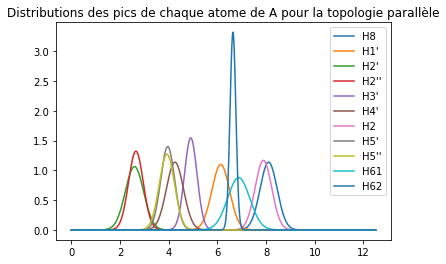

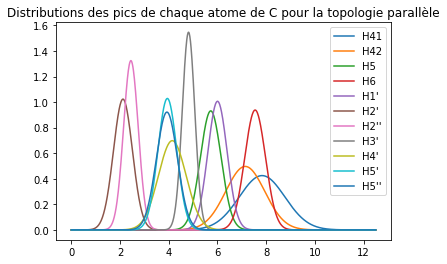

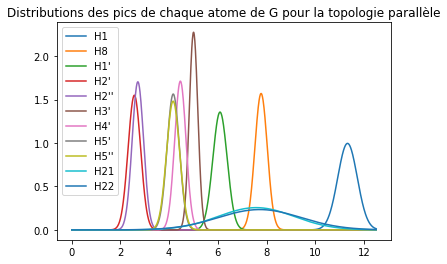

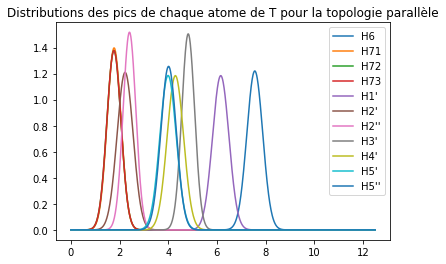

In [ ]:
def typo(name):
  if name[0] == '"':
    return name[1:-1]
  else:
    return name

plt.figure()
t = np.linspace(0,12.5,1000)
for (key,(mu,std)) in dict_param[0][0].items():
  plt.plot(t,norm.pdf(t,mu,std),label = typo(key))
plt.legend()
plt.title("Distributions des pics de chaque atome de A pour la topologie parallèle")
plt.show()


plt.figure()
t = np.linspace(0,12.5,1000)
for (key,(mu,std)) in dict_param[0][1].items():
  plt.plot(t,norm.pdf(t,mu,std),label = typo(key))
plt.legend()
plt.title("Distributions des pics de chaque atome de C pour la topologie parallèle")
plt.show()


plt.figure()
t = np.linspace(0,12.5,1000)
for (key,(mu,std)) in dict_param[0][2].items():
  plt.plot(t,norm.pdf(t,mu,std),label = typo(key))
plt.legend()
plt.title("Distributions des pics de chaque atome de G pour la topologie parallèle")
plt.show()


plt.figure()
t = np.linspace(0,12.5,1000)
for (key,(mu,std)) in dict_param[0][3].items():
  plt.plot(t,norm.pdf(t,mu,std),label = typo(key))
plt.legend()
plt.title("Distributions des pics de chaque atome de T pour la topologie parallèle")
plt.show()



# Correlation

In [ ]:
AtomsP = [[],[],[],[]]  #name of atoms for each nucleotid (parallel)

for k in range(4):
  for (key,x) in dict_list[0][k].items():
    AtomsP[k].append(key)

AtomsA = [[],[],[],[]]  #name of atoms for each nucleotid (antiparallel)

for k in range(4):
  for (key,x) in dict_list[1][k].items():
    AtomsA[k].append(key)

AtomsH = [[],[],[],[]]  #name of atoms for each nucleotid (hybrid)

Atoms = [AtomsP,AtomsA,AtomsH]

for k in range(4):
  for (key,x) in dict_list[2][k].items():
    AtomsH[k].append(key)

def create_dataframe(g4,topo):
  n = g4.iloc[-1,3]
  n_nuc_list = [len(Atoms[topo][0]),len(Atoms[topo][1]),len(Atoms[topo][2]),len(Atoms[topo][3])]
  M = [[],[],[],[]]
  for k in range(1,n+1):
    data_nuc = g4.loc[g4[3] == k,[5,6,9]]
    if not data_nuc.empty:
      if data_nuc.iloc[0,0] in ["DA","DC","DT","DG"]:
        nuc = basetonumber(data_nuc.iloc[0,0])
        n_nuc = n_nuc_list[nuc]
        atoms = Atoms[topo][nuc]
        l = n_nuc*[-1]
        for i in range(n_nuc):
          peak = data_nuc.loc[data_nuc[6] == atoms[i],9].values
          if len(peak)>0:
            l[i] = peak[0]
        M[nuc].append(l)
  return M

MP = [[],[],[],[]]
MA = [[],[],[],[]]
MH = [[],[],[],[]]

for data in Dataset:
  dataframe = data.dataframe
  topo = data.topo
  M = create_dataframe(dataframe,topo)
  if topo == 0:
    for k in range(4):
      MP[k] = MP[k] + M[k]
  if topo == 1:
    for k in range(4):
      MA[k] = MA[k] + M[k]
  if topo == 2:
    for k in range(4):
      MH[k] = MH[k] + M[k]




In [ ]:
A_P = pd.DataFrame(MP[0], columns = AtomsP[0])
C_P = pd.DataFrame(MP[1], columns = AtomsP[1])
G_P = pd.DataFrame(MP[2], columns = AtomsP[2])
T_P = pd.DataFrame(MP[3], columns = AtomsP[3])

A_A = pd.DataFrame(MA[0], columns = AtomsA[0])
C_A = pd.DataFrame(MA[1], columns = AtomsA[1])
G_A = pd.DataFrame(MA[2], columns = AtomsA[2])
T_A = pd.DataFrame(MA[3], columns = AtomsA[3])

A_H = pd.DataFrame(MH[0], columns = AtomsH[0])
C_H = pd.DataFrame(MH[1], columns = AtomsH[1])
G_H = pd.DataFrame(MH[2], columns = AtomsH[2])
T_H = pd.DataFrame(MH[3], columns = AtomsH[3])

dataframes = [A_P,C_P,G_P,T_P,A_A,C_A,G_A,T_A,A_H,C_H,G_H,T_H]


def missing_values(data):
  for c in data.columns:
    peaks = data.loc[data[c] != -1,c].values
    m = np.mean(peaks)
    for x in data.index:
      if data.loc[x,c] == -1:
        data.loc[x,c] = m

for data in dataframes:
  missing_values(data)




In [ ]:
dict_param_correl = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]

from scipy.stats import multivariate_normal

for k in range(12):
  i = k//4
  j = k%4
  data = dataframes[k].values
  mu = np.mean(data, axis = 0)
  cov = np.cov(data, rowvar = 0)
  dict_param_correl[i][j] = (mu,cov)

# Attribution

In [ ]:
def distance(l1,l2,index_map,f):
    d = 0
    for k in range(len(l1)):
        d += f(l1[k].freq,l2[index_map[k]].freq)
    return d

def two_opt(l1,l2,f): #l1 et l2 liste de peaks
    d_list = []
    #On commence comme avec l'algo naïf
    n1 = len(l1)
    n2 = len(l2)
    index_map = n1 * [-1]
    index_used = n2 * [0]
    for k in range(n1):
        d_min = np.inf
        ind_min = 0
        for j in range(n2):
            if index_used[j] == 0:
                d = f(l1[k].freq,l2[j].freq)
                if d < d_min:
                    d_min = d
                    ind_min = j
        index_used[ind_min] = 1
        index_map[k] = ind_min
    change = True
    d_list.append(distance(l1,l2,index_map,f))
    #puis on fait des modifs
    while change:
        change = False
        #ici on vérifie si la permutation de 2 attributions n'est pas meilleure
        for i in range(n1-1):
            for j in range(i+1,n1):
                if f(l2[index_map[i]].freq, l1[j].freq) + f(l2[index_map[j]].freq , l1[i].freq) < f(l2[index_map[i]].freq , l1[i].freq) + f(l2[index_map[j]].freq , l1[j].freq):
                    index_map[i],index_map[j] = index_map[j], index_map[i]
                    change = True
                    d_list.append(distance(l1,l2,index_map,f))
        #ici on vérifie si il n'y a pas un pic libre qui serait mieux (car on a modifié l'attribution juste avant)
        for i in range(n1):
            for j in range(n2):
                if index_used[j] == 0:
                    if f(l1[i].freq , l2[j].freq) < f(l1[i].freq , l2[index_map[i]].freq):
                        index_used[j] = 1
                        index_used[index_map[i]] = 0
                        index_map[i] = j
                        change = True
                        d_list.append(distance(l1,l2,index_map,f))
    # plt.figure()
    # plt.plot([k for k in range(len(d_list))],d_list)
    # plt.title("Optimisation 2 opt")
    # plt.show()
    return index_map


In [ ]:
def sample_spectre(nA,nC,nG,nT,topo): #topo = 0,1,2
  # on crée un spectre aléatoire en respectant le nombre de nucléotides et en suivant les lois normales calibrées avant
    peaks = []
    nuc = ["DA","DC","DG","DT"]
    n_list = [nA,nC,nG,nT]
    params = dict_param[topo]
    for k in range(4):
        n = n_list[k]
        for iteration in range(n):
            for (key,v) in params[k].items():
                mu,std = v
                peaks.append(peak(np.random.normal(mu,std),nuc[k],key))
    return peaks

def sample_spectre_correl(nA,nC,nG,nT,topo): #topo = 0,1,2
  # on crée un spectre aléatoire en respectant le nombre de nucléotides et en suivant les lois normales calibrées avant
    peaks = []
    nuc = ["DA","DC","DG","DT"]
    n_list = [nA,nC,nG,nT]
    for k in range(4):
        n = n_list[k]
        mu,cov = dict_param_correl[topo][k]
        for iteration in range(n):
            samples = np.random.multivariate_normal(mu,cov)
            peaks_samples = []
            for i in range(len(samples)):
              peaks_samples.append(peak(samples[k],nuc[k],Atoms[topo][k][i]))
            peaks = peaks + peaks_samples
    return peaks


In [ ]:
!pip install mip
from scipy import optimize
from mip import *

def create_distance_matrix(l1,l2,f):
    M = np.zeros((len(l1),len(l2)))
    for i in range(len(l1)):
        for j in range(len(l2)):
            M[i,j] = f(l1[i].freq,l2[j].freq)
    return M

     |████████████████████████████████| 48.0 MB 61.4 MB/s 


In [ ]:
def mip_solver(l1,l2,f):  # Algo basé sur l'optimisation discrète sous contraintes
    n1 = len(l1)
    n2 = len(l2)
    m = Model()
    distance_matrix = create_distance_matrix(l1,l2,f)
    x = [[m.add_var(var_type=BINARY) for j in range(n2)] for i in range(n1)]
    m.objective = minimize(xsum(distance_matrix[i][j]*x[i][j] for i in range(n1) for j in range(n2)))

    for i in range(n1):
        m += xsum(x[i][j] for j in range(n2)) == 1

    for j in range(n2):
        m += xsum(x[i][j] for i in range(n1)) <= 1

    m.optimize()

    matrix = []
    for v in m.vars:
        matrix.append(v.x)

    matrix_1 = np.array(matrix).reshape((n1,n2))
    value1=m.objective_value
    index_map = n1 * [0]
    for i in range(n1):
      index_map[i] = np.argmax(matrix_1[i])
    return index_map,value1

In [ ]:
class predict_peak:
  def __init__(self,peak,nuc_pred,atom_pred):
    self.freq = peak.freq
    self.nuc = peak.nuc
    self.atom = peak.atom
    self.nuc_pred = nuc_pred
    self.atom_pred = atom_pred

f = lambda x,y : (x-y)**2

def attribution_2opt(data,f):
  nA,nC,nG,nT = data.nA,data.nC,data.nG,data.nT
  topo = data.topo

  peaks_sample = sample_spectre(nA,nC,nG,nT,topo)

  peaks_real = get_spectre(data.dataframe)

  index_map = two_opt(peaks_real,peaks_sample,f)
  peaks = []
  for k in range(len(peaks_real)):
    peak_attrib = peaks_sample[index_map[k]]
    peaks.append(predict_peak(peaks_real[k],peak_attrib.nuc,peak_attrib.atom))
  return peaks,distance(peaks_real,peaks_sample,index_map,f)

def attribution_mip(data,f):
  nA,nC,nG,nT = data.nA,data.nC,data.nG,data.nT
  topo = data.topo

  peaks_sample = sample_spectre(nA,nC,nG,nT,topo)

  peaks_real = get_spectre(data.dataframe)

  index_map,value = mip_solver(peaks_real,peaks_sample,f)
  peaks = []
  for k in range(len(peaks_real)):
    peak_attrib = peaks_sample[index_map[k]]
    peaks.append(predict_peak(peaks_real[k],peak_attrib.nuc,peak_attrib.atom))
  return peaks,value

def accuracy(peaks):
  acc_nuc = 0
  acc_atom = 0
  acc = 0
  n = len(peaks)
  for k in range(n):
    peak_pred = peaks[k]
    if peak_pred.nuc == peak_pred.nuc_pred:
      acc_nuc += 1
      if peak_pred.atom == peak_pred.atom_pred:
        acc_atom += 1
        acc +=1
    elif peak_pred.atom == peak_pred.atom_pred:
        acc_atom += 1
  return [acc_nuc/n, acc_atom/n, acc/n]

def iter_2opt(data,f,n_iter):
  min = 99999
  peaks = []
  for k in range(n_iter):
    p,d = attribution_2opt(data,f)
    if d < min:
      min = d
      peaks = p
  return peaks



In [ ]:
## Accuracy moyenne sur tout le dataset

Acc_2opt = []

Acc_mip = []

count = 0


for data in Dataset:
    peaks_2opt = iter_2opt(data,f,3)
    #peaks_mip,d = attribution_mip(data,f)
    Acc_2opt.append(accuracy(peaks_2opt))
    #Acc_mip.append(accuracy(peaks_mip))


Acc_2opt = np.array(Acc_2opt)
Acc_mip = np.array(Acc_mip)


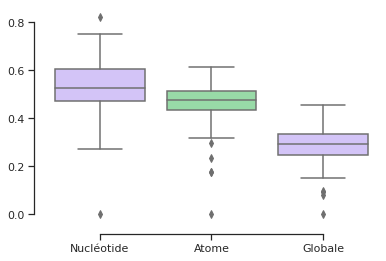

In [ ]:
twoopt_dataframe = pd.DataFrame(Acc_2opt, columns = ['Nucléotide', 'Atome', 'Globale']).assign(Method = "2opt")
#mip_dataframe = pd.DataFrame(Acc_mip, columns = ['Nucléotide', 'Atome', 'Globale']).assign(Method = "mip")

import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot( palette=["m", "g"],
            data= twoopt_dataframe)
sns.despine(offset=10, trim=True)

L'attribution change énormément entre 2 exécutions.

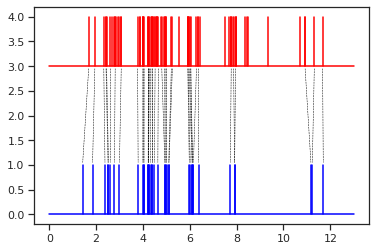

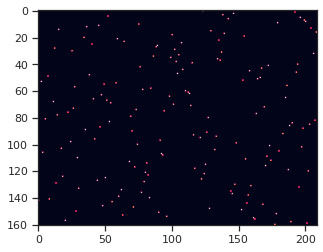

In [ ]:
data = Dataset[11]

def plot_attribution(data,f):
  nA,nC,nG,nT = data.nA,data.nC,data.nG,data.nT
  topo = data.topo

  peaks_sample = sample_spectre(nA,nC,nG,nT,topo)

  peaks_real = get_spectre(data.dataframe)

  n = len(peaks_real)

  ind_peaks = np.random.choice([k for k in range(n)],40,replace = False)
  plt.figure()
  plt.plot([0,13],[0,0],color = "black")
  plt.plot([0,13],[3,3],color = "red")

  for k in ind_peaks:
    plt.plot([peaks_real[k].freq,peaks_real[k].freq],[0,1],"black")
    plt.plot([peaks_sample[k].freq,peaks_sample[k].freq],[3,4],"red")

  index_map,v  = mip_solver(peaks_real,peaks_sample,f)
  peaks = []
  P = np.zeros((n,len(peaks_sample)))
  for i in range(n):
    P[i,index_map[i]] = 1
  for k in range(len(peaks_real)):
    peak_attrib = peaks_sample[index_map[k]]
    if k in ind_peaks:
      plt.plot([peak_attrib.freq,peak_attrib.freq],[3,4],"red")
      plt.plot([peak_attrib.freq,peaks_real[k].freq],[2.95,1.05], "--",linewidth = 0.5,color = "black")
    peaks.append(predict_peak(peaks_real[k],peak_attrib.nuc,peak_attrib.atom))
  plt.show()
  plt.figure(figsize = (5,5))
  plt.imshow(P)
  plt.show()

plot_attribution(data,f)



NameError: ignored

# Other method


In [ ]:
n0 = len(dict_param[0][0])
n1 = len(dict_param[0][1])
n2 = len(dict_param[0][2])
n3 = len(dict_param[0][3])

print(n0+n1+n2+n3)

44


In [ ]:
def likelihood_matrix(peaks,topo):   #ici on remplace la matrice des distances par la matrice des probabilités d'appartenance à chaque normale
# on a donc pour chaque pic une liste de proba d'appartenance à chaque atome de chaque nucléotide
  n0 = len(dict_param[topo][0])
  n1 = len(dict_param[topo][1])
  n2 = len(dict_param[topo][2])
  n3 = len(dict_param[topo][3])
  n_list = [n0,n1,n2,n3]
  n_normales = np.sum(n_list)
  n_peaks = len(peaks)
  M = np.zeros((n_peaks,n_normales))
  for i in range(n_peaks):
    for k in range(4):
      upset = np.sum(n_list[:k])
      c = 0
      for (key,param) in dict_param[topo][k].items():
        (mu,std) = param
        p = norm.pdf(peaks[i].freq,mu,std+0.003)
        if p< 0.0001:
          d = -np.log(0.0001)
        else:
          d = -np.log(p)
        M[i,int(upset+c)] = d
        c +=1
  return M

def likelihood_matrix_bis(peaks,topo,nA,nC,nG,nT):   #ici on remplace la matrice des distances par la matrice des probabilités d'appartenance à chaque normale
# on a donc pour chaque pic une liste de proba d'appartenance à chaque atome de chaque nucléotide
  n0 = len(dict_param[topo][0])
  n1 = len(dict_param[topo][1])
  n2 = len(dict_param[topo][2])
  n3 = len(dict_param[topo][3])
  n_list = [n0,n1,n2,n3]
  n_nuc = [nA,nC,nG,nT]
  nsum = np.sum(n_nuc)
  n_normales = np.sum(n_list)
  n_peaks = len(peaks)
  M = np.zeros((n_peaks,n_normales))
  for i in range(n_peaks):
    for k in range(4):
      upset = np.sum(n_list[:k])
      c = 0
      for (key,param) in dict_param[topo][k].items():
        (mu,std) = param
        p = n_nuc[k]/nsum*norm.pdf(peaks[i].freq,mu,std+0.003)
        d = -np.log(p)
        M[i,int(upset+c)] = d
        c +=1
  return M

def mip_solver_likelihood(peaks,topo,nA,nC,nG,nT):  #même algo qu'avant mais en utilisant la matrice likelihood
    m = Model()
    distance_matrix = likelihood_matrix(peaks,topo)
    n_peaks = len(distance_matrix)
    n_params = len(distance_matrix[0])
    x = [[m.add_var(var_type=BINARY) for j in range(n_params)] for i in range(n_peaks)]
    m.objective = minimize(xsum(distance_matrix[i][j]*x[i][j] for i in range(n_peaks) for j in range(n_params)))

    for i in range(n_peaks):
        m += xsum(x[i][j] for j in range(n_params)) == 1

    n0 = len(dict_param[topo][0])
    n1 = len(dict_param[topo][1])
    n2 = len(dict_param[topo][2])
    n3 = len(dict_param[topo][3])

    for j in range(n0):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nA
        #m += xsum(x[i][j] for i in range(n_peaks)) >= nA//2
    for j in range(n0,n0+n1):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nC
        #m += xsum(x[i][j] for i in range(n_peaks)) >= nC//2
    for j in range(n0+n1,n0+n1+n2):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nG
        #m += xsum(x[i][j] for i in range(n_peaks)) >= nG//2
    for j in range(n0+n1+n2,n_params):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nT
        #m += xsum(x[i][j] for i in range(n_peaks)) >= nT//2

    m.optimize()

    matrix = []
    for v in m.vars:
        matrix.append(v.x)

    matrix_1 = np.array(matrix).reshape((n_peaks,n_params))
    value1=m.objective_value
    index_map = n_peaks * [0]
    for i in range(n_peaks):
      index_map[i] = np.argmax(matrix_1[i])
    return index_map,value1


def mip_solver_likelihood_weighted(peaks,topo,nA,nC,nG,nT):  #même algo qu'avant mais en utilisant la matrice likelihood
    m = Model()
    distance_matrix = likelihood_matrix_bis(peaks,topo,nA,nC,nG,nT)
    n_peaks = len(distance_matrix)
    n_params = len(distance_matrix[0])
    x = [[m.add_var(var_type=BINARY) for j in range(n_params)] for i in range(n_peaks)]
    m.objective = minimize(xsum(distance_matrix[i][j]*x[i][j] for i in range(n_peaks) for j in range(n_params)))

    for i in range(n_peaks):
        m += xsum(x[i][j] for j in range(n_params)) == 1

    n0 = len(dict_param[topo][0])
    n1 = len(dict_param[topo][1])
    n2 = len(dict_param[topo][2])
    n3 = len(dict_param[topo][3])

    for j in range(n0):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nA
        #m += xsum(x[i][j] for i in range(n_peaks)) >= nA//2
    for j in range(n0,n0+n1):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nC
        #m += xsum(x[i][j] for i in range(n_peaks)) >= nC//2
    for j in range(n0+n1,n0+n1+n2):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nG
        #m += xsum(x[i][j] for i in range(n_peaks)) >= nG//2
    for j in range(n0+n1+n2,n_params):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nT
        #m += xsum(x[i][j] for i in range(n_peaks)) >= nT//2

    m.optimize()

    matrix = []
    for v in m.vars:
        matrix.append(v.x)

    matrix_1 = np.array(matrix).reshape((n_peaks,n_params))
    value1=m.objective_value
    index_map = n_peaks * [0]
    for i in range(n_peaks):
      index_map[i] = np.argmax(matrix_1[i])
    return index_map,value1

In [ ]:
data = Dataset[0]
topo = data.topo

list_labels = [[],[],[]]
for topo in range(3):
  for k in range(4):
      for (key,atom) in dict_list[topo][k].items():
        list_labels[topo].append((k,key))



def numbertobase(x):
  if x==0:
    return "DA"
  elif x == 1:
    return "DC"
  elif x ==2:
    return "DG"
  elif x == 3:
    return "DT"


def attribution_likelihood(data,f):
  topo = data.topo
  peaks_real = get_spectre(data.dataframe)
  index_map,value = mip_solver_likelihood(peaks_real,topo,data.nA,data.nC,data.nG,data.nT)
  peaks = []
  for k in range(len(peaks_real)):
    ind = index_map[k]
    l,atom = list_labels[topo][ind]
    peaks.append(predict_peak(peaks_real[k],numbertobase(l),atom))
  return peaks



def attribution_likelihood_weighted(data,f):
  topo = data.topo
  peaks_real = get_spectre(data.dataframe)
  index_map,value = mip_solver_likelihood_weighted(peaks_real,topo,data.nA,data.nC,data.nG,data.nT)
  peaks = []
  for k in range(len(peaks_real)):
    ind = index_map[k]
    l,atom = list_labels[topo][ind]
    peaks.append(predict_peak(peaks_real[k],numbertobase(l),atom))
  return peaks



1
2
3
4
5
6
7


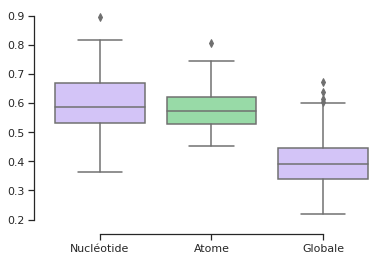

In [ ]:
## Accuracy moyenne sur tout le dataset

Acc = []
c = 0
n = len(Dataset)
for data in Dataset:
  try:
    Acc.append(accuracy(attribution_likelihood(data,f)))
  except TypeError:
    c+=1
    print(c)


Acc = np.array(Acc)

acc_dataframe = pd.DataFrame(Acc, columns = ['Nucléotide', 'Atome', 'Globale'])


import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot( palette=["m", "g"],
            data = acc_dataframe)
sns.despine(offset=10, trim=True)


In [ ]:
plt.figure()
plt.boxplot([mean_acc_nuc,mean_acc_atom,mean_acc_all])
plt.title("Accuracy nuclétodie                 Accuracy atome            Accuracy all")
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
## Affiche le spectre en montrant les pics justes et faux

nA,nC,nG,nT = nb_base(nameH[6])
topo = 0

real_sp, label_nuc, label_atom = get_spectre(databaseH[6])

index_map_likelihood, value = mip_solver_likelihood(real_sp,topo,nA,nC,nG,nT)

list_labels = []
for k in range(4):
    for (key,atom) in dict_list[topo][k].items():
      list_labels.append((k,key))

def get_nuc_atom(index_map):
  n = len(index_map)
  label_nuc = []
  label_atom = []
  for k in range(n):
    ind = index_map[k]
    k,atom = list_labels[ind]
    label_nuc.append(k)
    label_atom.append(atom)
  return label_nuc,label_atom

label_nuc_pred, label_atom_pred = get_nuc_atom(index_map_likelihood)

plt.figure()
cg = 0
cb = 0
cp = 0
cr = 0
for k in range(len(real_sp)):
    if label_nuc_pred[k] == basetonumber(label_nuc[k]):
      if label_atom_pred[k] == label_atom[k]:
        if cg == 0:
          plt.plot([real_sp[k],real_sp[k]],[0,1],color = "green",label = "bonne attribution")
          cg+=1
        else:
          plt.plot([real_sp[k],real_sp[k]],[0,1],color = "green")
      else:
        if cb == 0:
          plt.plot([real_sp[k],real_sp[k]],[0,1],color = "blue",label = "bon nucléotide")
          cb += 1
        else:
          plt.plot([real_sp[k],real_sp[k]],[0,1],color = "blue")
    elif label_atom_pred[k] == label_atom[k]:
      if cp == 0:
        plt.plot([real_sp[k],real_sp[k]],[0,1],color = "pink", label = "bon atome")
        cp += 1
      else:
        plt.plot([real_sp[k],real_sp[k]],[0,1],color = "pink")
    else:
      if cr == 0:
        plt.plot([real_sp[k],real_sp[k]],[0,1],color = "red",label = "mauvaise attribution")
        cr += 1
      else:
        plt.plot([real_sp[k],real_sp[k]],[0,1],color = "red")
plt.legend()
plt.show()

## Liste des meilleurs candidats

In [ ]:
def insert_sort(l,x,eval,n_max):
  if l == []:
    l.append(x)
  else:
    n = len(l)
    i = 0
    while i < n and eval(x) > eval(l[i]) :
      i+=1
    l = l[:i]+[x]+l[i:]
    if n+1 > n_max:
      l = l[1:]
  return l


class label:
  def __init__(self,nuc,atom,p):
    self.nuc = nuc
    self.atom = atom
    self.proba = p

def pred_list(data,n_list):
  topo = data.topo
  peaks = get_spectre(data.dataframe)
  peaks_pred_list = []
  eval = lambda label : label.proba
  for peak in peaks:
    pred = []
    for k in range(4):
      for (key,param) in dict_param[topo][k].items():
        (mu,std) = param
        p = norm.pdf(peak.freq,mu,std+0.001)
        lab = label(numbertobase(k),key,p)
        pred = insert_sort(pred,lab,eval,n_list)
    peaks_pred_list.append(pred)
  return peaks_pred_list

def accuracy_list_pred(data,n_list):
  peaks_pred_list = pred_list(data,n_list)
  acc = n_list * [0]
  peaks = get_spectre(data.dataframe)
  for k in range(len(peaks)):
    peak = peaks[k]
    nuc,atom = peak.nuc,peak.atom
    predictions = peaks_pred_list[k][::-1]
    for n_pred in range(1,n_list+1):
      for pred in predictions[:n_pred]:
        if pred.nuc == nuc and pred.atom == atom:
          acc[n_pred - 1] = acc[n_pred - 1] + 1
          break
  acc = np.array(acc)/len(peaks)*100
  return acc

accuracy_list_pred(Dataset[10],3)

In [ ]:
n_list = 5
N = [k for k in range(1,n_list+1)]

Mean_acc = np.zeros((len(Dataset),len(N)))


for k in range(len(Dataset)):
  data = Dataset[k]
  Mean_acc[k,:] = accuracy_list_pred(data,n_list)

pred_dataframe = pd.DataFrame(Mean_acc, columns = ['1 choix','2 choix','3 choix','4 choix','5 choix'])
pred_dataframe = pred_dataframe.loc[pred_dataframe['1 choix'] != 0]

import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot( palette=["m", "g"],
            data= pred_dataframe)
sns.despine(offset=10, trim=True)


## other method

In [ ]:
# attribution selon fréquence d'attribution avec première méthode

def numbertobase(x):
  if x==0:
    return "DA"
  elif x == 1:
    return "DC"
  elif x ==2:
    return "DG"
  elif x == 3:
    return "DT"

nA,nC,nG,nT = nb_base(nameP[10])
topo = 0



real_sp, label_nuc, label_atom = get_spectre(databaseP[10])
attributions_nuc_atom = []
for k in range(len(real_sp)):
  attributions_nuc_atom.append([])

N = 1

for iteration in range(N):
  sp,nuc,atom = sample_spectre(nA,nC,nG,nT,topo)
  index_map_2opt = two_opt(real_sp,sp,f)
  for k in range(len(real_sp)):
    attributions_nuc_atom[k].append((nuc[index_map_2opt[k]],atom[index_map_2opt[k]]))  #pour chaque pic on garde la liste des labels pour chaque exécution

def frequence(l):
  dico = {}
  c = 0
  for x in l:
    c+=1
    if str(x) in dico:
      dico[str(x)] +=1
    else:
      dico[str(x)] = 1
  for (key,f) in dico.items():
    dico[key] = f/c
  return dico   #contient les fréquences des éléments de l

def frequence_matrix(peaks,dico_list): #dico_list contient un dictionnaire de fréquence pour chaque peak
  n0 = len(dict_param[topo][0])
  n1 = len(dict_param[topo][1])
  n2 = len(dict_param[topo][2])
  n3 = len(dict_param[topo][3])
  n_list = [n0,n1,n2,n3]
  n_normales = np.sum(n_list)
  n_peaks = len(peaks)
  M = np.zeros((n_peaks,n_normales))
  for i in range(n_peaks):
    for k in range(4):
      upset = np.sum(n_list[:k])
      c = 0
      for (key,param) in dict_param[topo][k].items():
        if (numbertobase(k),key) in dico_list[i]:
          M[i,int(upset+c)] = - dico_list[i][(numbertobase(k),key)]
        c +=1
  return M

dico_list = []
for l in attributions_nuc_atom:
  dico_list.append(frequence(l))

M = frequence_matrix(real_sp,dico_list)

def mip_solver_frequence(peaks,topo,nA,nC,nG,nT,M):  #M est la matrice de fréquences
    m = Model()
    n_peaks = len(peaks)
    n_params = len(M[0])
    x = [[m.add_var(var_type=BINARY) for j in range(n_params)] for i in range(n_peaks)]
    m.objective = minimize(xsum(M[i][j]*x[i][j] for i in range(n_peaks) for j in range(n_params)))

    for i in range(n_peaks):
        m += xsum(x[i][j] for j in range(n_params)) == 1

    n0 = len(dict_param[topo][0])
    n1 = len(dict_param[topo][1])
    n2 = len(dict_param[topo][2])
    n3 = len(dict_param[topo][3])

    for j in range(n0):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nA
    for j in range(n0,n0+n1):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nC
    for j in range(n0+n1,n0+n1+n2):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nG
    for j in range(n0+n1+n2,n_params):
        m += xsum(x[i][j] for i in range(n_peaks)) <= nT

    m.optimize()

    matrix = []
    for v in m.vars:
        matrix.append(v.x)

    matrix_1 = np.array(matrix).reshape((n_peaks,n_params))
    value1=m.objective_value
    index_map = n_peaks * [0]
    for i in range(n_peaks):
      index_map[i] = np.argmax(matrix_1[i])
    return index_map,value1

index_map_freq, value = mip_solver_frequence(real_sp,topo,nA,nC,nG,nT,M)

label_nuc_pred, label_atom_pred = get_nuc_atom(index_map_freq)

acc_nuc_freq = 0
acc_atom_freq = 0
acc_all_freq = 0
for k in range(len(real_sp)):
    if label_nuc_pred[k] == basetonumber(label_nuc[k]):
      acc_nuc_freq +=1
      if label_atom_pred[k] == label_atom[k]:
        acc_atom_freq +=1
        acc_all_freq += 1
    elif label_atom_pred[k] == label_atom[k]:
        acc_atom_freq +=1


print("nuc acc : "+str(acc_nuc_freq/len(real_sp))+"    ;    atom acc : "+str(acc_atom_freq/len(real_sp))+"   ;   both acc : "+str(acc_all_freq/len(real_sp)))



# Kantorovitch Relaxation (bad idea)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [ ]:
def kantorovitch(peaks1,peaks2):
  n = len(peaks1)
  m = len(peaks2)
  C = np.zeros((n,m))
  for i in range(n):
    for j in range(m):
      C[i,j] = (peaks1[i].freq - peaks2[j].freq)**2

  P = cp.Variable((n,m))

  u = np.ones((m,1))
  v = np.ones((n,1))
  U = [0 <= P, cp.matmul(P,u)<=1, cp.matmul(P.T,v)<=1]
  objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
  prob = cp.Problem(objective, U)
  result = prob.solve()
  return P

In [ ]:
class pred:
  def __init__(self,nuc,atom,proba):
    self.nuc = nuc
    self.atom = atom
    self.proba = proba

class K_predict_peak:
  def __init__(self,peak,preds):
    self.freq = peak.freq
    self.nuc = peak.nuc
    self.atom = peak.atom
    self.preds = preds


def attribution_kantorovitch(data):
  nA,nC,nG,nT = data.nA,data.nC,data.nG,data.nT
  topo = data.topo

  peaks_sample = sample_spectre(nA,nC,nG,nT,topo)

  peaks_real = get_spectre(data.dataframe)

  P = kantorovitch(peaks_real,peaks_sample)
  Pvalue = P.value
  peaks_pred = []
  plt.figure()
  plt.plot([0,13],[0,0],color = "blue")
  plt.plot([0,13],[3,3],color = "red")
  ind_peaks = np.random.choice([k for k in range(len(peaks_real))],30,replace = False)
  for k in ind_peaks:
    plt.plot([peaks_real[k].freq,peaks_real[k].freq],[0,1],"blue")
  for j in range(len(peaks_sample)):
    plt.plot([peaks_sample[j].freq,peaks_sample[j].freq],[3,4],"red")
  for k in range(len(peaks_real)):
    preds = []
    for j in range(len(peaks_sample)):
      if Pvalue[k,j] != 0:
        if k in ind_peaks:
          plt.plot([peaks_sample[j].freq,peaks_sample[j].freq],[3,4],"red")
          plt.plot([peaks_sample[j].freq,peaks_real[k].freq],[2.95,1.05], color = "black")
        peak = peaks_sample[j]
        preds.append(pred(peak.nuc,peak.atom,Pvalue[k,j]))
    peaks_pred.append(K_predict_peak(peaks_real[k],preds))
  plt.show()
  return peaks_pred

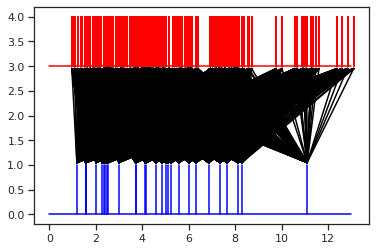

In [ ]:
data = Dataset[2]
nA,nC,nG,nT = data.nA,data.nC,data.nG,data.nT
topo = data.topo

peaks_sample = sample_spectre(nA,nC,nG,nT,topo)

peaks_real = get_spectre(data.dataframe)

peaks_pred = attribution_kantorovitch(data)